# Deep Generative Models on LINCS Data

Latent representations learning for LINCS L1000 expression profiles with Variational AutoEncoder (VAE) and Supervised Vector-Quantized Variational Autoencoder (S-VQ-VAE).

For a more detailed tutorial of how to S-VQ-VAE on other dataset, please refer to https://github.com/evasnow1992/S-VQ-VAE.

In [2]:
from __future__ import division
import sys
import math
import time
import operator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cmapPy as cp
from cmapPy.pandasGEXpress.parse import parse
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data as Tdata
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

Major cell lines that contain over 10,000 samples from GSE70138 and GSE106127.

In [3]:
cellLineNameSM = set(["A375", "HA1E", "HELA", "HT29", "MCF7", "PC3", "YAPC"])
cellLineNameGP = set(["A375", "A549", "HA1E", "HCC515", "HEPG2", "HT29", "MCF7", "PC3", "VCAP"])

## Load GSE70138 small molecular perturbation L1000 data

### Load signature metadata

In [4]:
sigFileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_sig_info_2017-03-06.txt"
sigInfoSM = pd.read_csv(sigFileNameSM, sep = "\t")
cellLineInfoSM = sigInfoSM[sigInfoSM["cell_id"].isin(cellLineNameSM)]
cellLineSigSM = cellLineInfoSM["sig_id"]
cellLinePertSM = cellLineInfoSM["pert_id"]
cellLinePertTypeSM = cellLineInfoSM["pert_type"]
print(sigInfoSM.shape)
print(cellLineInfoSM.shape)

(118050, 8)
(85183, 8)


In [5]:
pertDicSM = {}
pertArraySM = cellLinePertSM.values
for i in range(len(pertArraySM)):
    pertSM = pertArraySM[i]
    c = pertDicSM.setdefault(pertSM, 0)
    pertDicSM[pertSM] = c + 1
print("The number of perturbagens: " + str(len(pertDicSM)))

The number of perturbagens: 1797


### Load gene information

In [6]:
geneFileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_gene_info_2017-03-06.txt"
geneInfoSM = pd.read_csv(geneFileNameSM, sep = "\t")
lmInfoSM = geneInfoSM["pr_gene_id"][geneInfoSM["pr_is_lm"] == 1].astype(str) # landmark genes only
print(geneInfoSM.shape)
print(lmInfoSM.shape)

(12328, 5)
(978,)


### Load perturbagen class (PCL) information

In [7]:
pclFileNameSM = "../Data/YX_Data/pcl_information.csv"
pertClassDicSM = {}
classDicSM = {}
pertCountSM = 0
with open(pclFileNameSM, "r") as myfile:
    for line in myfile.readlines():
        if not len(line):
            continue
        pertCountSM += 1
        line = line.strip()
        spline = line.split(',')
        pertClassDicSM[spline[0]] = spline[1]
        c = classDicSM.setdefault(spline[1], 0)
        classDicSM[spline[1]] = c + 1
print("The number of perturbagens with class information: " + str(pertCountSM))
print("The number of PCL: " + str(len(classDicSM)))
print(sorted(classDicSM.items(), key = operator.itemgetter(1), reverse = True)[0])

The number of perturbagens with class information: 991
The number of PCL: 171
('CP_GLUCOCORTICOID_RECEPTOR_AGONIST', 44)


In [8]:
overlapPertDicSM = {}
overLapPertClassDicSM = {}
overLapPertClassCountSM = {}
for pert in pertDicSM:
    if pert in pertClassDicSM:
        overlapPertDicSM[pert] = 1
        c = overLapPertClassDicSM.setdefault(pertClassDicSM[pert], 0)
        overLapPertClassDicSM[pertClassDicSM[pert]] = c + 1
        c = overLapPertClassCountSM.setdefault(pertClassDicSM[pert], 0)
        overLapPertClassCountSM[pertClassDicSM[pert]] = c + pertDicSM[pert]
print("The number of perturbagens with class information: " + str(len(overlapPertDicSM)))
print("The number of classes of overlap perturbagens: " + str(len(overLapPertClassDicSM)))
print(sorted(overLapPertClassDicSM.items(), key = operator.itemgetter(1), reverse = True)[0])
print(sorted(overLapPertClassCountSM.items(), key = operator.itemgetter(1), reverse = True)[0])

The number of perturbagens with class information: 204
The number of classes of overlap perturbagens: 75
('CP_DOPAMINE_RECEPTOR_ANTAGONIST', 12)
('CP_PROTEASOME_INHIBITOR', 2352)


### Load and process all L1000 data

In [9]:
L1000FileNameSM = "../Data/L1000/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx"
gctoo_cellLineSM = parse(L1000FileNameSM, cid = cellLineSigSM, rid = lmInfoSM)
print(gctoo_cellLineSM.data_df.shape)
print(max(gctoo_cellLineSM.data_df.max()))
print(min(gctoo_cellLineSM.data_df.min()))

(978, 85183)
10.0000019073
-10.0000019073


In [10]:
expDataSM = torch.Tensor(gctoo_cellLineSM.data_df.transpose().values.astype(np.float32))
expDatasetSM = Tdata.TensorDataset(expDataSM)

### Load and process L1000 data with PCL information

In [11]:
cellLineInfoSMC = cellLineInfoSM[cellLineInfoSM["pert_id"].isin(pertClassDicSM)]
cellLineSigSMC = cellLineInfoSMC["sig_id"]
gctoo_cellLineSMC = parse(L1000FileNameSM, cid = cellLineSigSMC, rid = lmInfoSM)
print(cellLineInfoSMC.shape)
print(gctoo_cellLineSMC.data_df.shape)

(12079, 8)
(978, 12079)


In [12]:
expDataSMC = torch.Tensor(gctoo_cellLineSMC.data_df.transpose().values.astype(np.float32))
pertClassTargetDicSM = {}
pertClassTargetIndexSM = 0
for pert in overlapPertDicSM:
    if pertClassDicSM[pert] not in pertClassTargetDicSM:
        pertClassTargetDicSM[pertClassDicSM[pert]] = pertClassTargetIndexSM
        pertClassTargetIndexSM += 1
pertClassTargetArraySM = np.zeros((expDataSMC.size()[0]))
targetIndex = 0
for sig in gctoo_cellLineSMC.data_df.transpose().index.values:
    pert = cellLineInfoSMC[cellLineInfoSMC["sig_id"] == sig]["pert_id"].values[0]
    pertClass = pertClassDicSM[pert]
    pertClassIndex = pertClassTargetDicSM[pertClass]
    pertClassTargetArraySM[targetIndex] = pertClassIndex
    targetIndex += 1
nClassSMC = len(pertClassTargetDicSM)
print("The number of PCL: " + str(nClassSMC))
pertClassTargetSM = torch.LongTensor(pertClassTargetArraySM)

The number of PCL: 75


In [13]:
expDatasetSMC = Tdata.TensorDataset(expDataSMC, pertClassTargetSM)

### Load and process L1000 data without perturbagen 'MG-31' and 'bortezomib'

In [14]:
excludePertDicSM = {'MG-132': 1, 'bortezomib': 1}
cellLineInfoSMNP = cellLineInfoSM[~cellLineInfoSM["pert_iname"].isin(excludePertDicSM)]
cellLineSigSMNP = cellLineInfoSMNP["sig_id"]
gctoo_cellLineSMNP = parse(L1000FileNameSM, cid = cellLineSigSMNP, rid = lmInfoSM)
print(cellLineInfoSMNP.shape)
print(gctoo_cellLineSMNP.data_df.shape)

(80534, 8)
(978, 80534)


In [15]:
expDataSMNP = torch.Tensor(gctoo_cellLineSMNP.data_df.transpose().values.astype(np.float32))
expDatasetSMNP = Tdata.TensorDataset(expDataSMNP)

### Load and process L1000 data with PCL information and without perturbagen 'MG-31'

In [16]:
excludePertDicSMC = {'MG-132': 1}
cellLineInfoSMCNP = cellLineInfoSMC[~cellLineInfoSMC["pert_iname"].isin(excludePertDicSMC)]
cellLineSigSMCNP = cellLineInfoSMCNP["sig_id"]
gctoo_cellLineSMCNP = parse(L1000FileNameSM, cid = cellLineSigSMCNP, rid = lmInfoSM)
print(cellLineInfoSMCNP.shape)
print(gctoo_cellLineSMCNP.data_df.shape)

(9769, 8)
(978, 9769)


In [17]:
expDataSMCNP = torch.Tensor(gctoo_cellLineSMCNP.data_df.transpose().values.astype(np.float32))
pertClassTargetArraySMNP = np.zeros((expDataSMCNP.size()[0]))
targetIndex = 0
tempPertDic = {}
for sig in gctoo_cellLineSMCNP.data_df.transpose().index.values:
    pert = cellLineInfoSMCNP[cellLineInfoSMCNP["sig_id"] == sig]["pert_id"].values[0]
    pertClass = pertClassDicSM[pert]
    pertClassIndex = pertClassTargetDicSM[pertClass]
    pertClassTargetArraySMNP[targetIndex] = pertClassIndex
    tempPertDic[pertClassIndex] = 1
    targetIndex += 1
print("The number of PCL: " + str(len(tempPertDic)))
pertClassTargetSMNP = torch.LongTensor(pertClassTargetArraySMNP)
expDatasetSMCNP = Tdata.TensorDataset(expDataSMCNP, pertClassTargetSMNP)

The number of PCL: 75


## Load GSE106127 genetic perturbation L1000 data

### Load signature metadata

In [18]:
sigFileNameGP = "../Data/L1000/GSE106127_sig_info.txt"
sigInfoGP = pd.read_csv(sigFileNameGP, sep = "\t")
cellLineInfoGP = sigInfoGP[sigInfoGP["cell_id"].isin(cellLineNameGP)]
cellLineSigGP = cellLineInfoGP["sig_id"]
cellLinePertGP = cellLineInfoGP["pert_iname"]
cellLinePertTypeGP = cellLineInfoGP["pert_type"]
print(sigInfoGP.shape)
print(cellLineInfoGP.shape)

(119013, 11)
(116782, 11)


In [19]:
pertDicGP = {}
pertArrayGP = cellLinePertGP.values
for i in range(len(pertArrayGP)):
    pertGP = pertArrayGP[i]
    c = pertDicGP.setdefault(pertGP, 0)
    pertDicGP[pertGP] = c + 1
print("The number of perturbagens: " + str(len(pertDicGP)))

The number of perturbagens: 4314


### Load and process L1000 data

In [20]:
L1000FileNameGP = "../Data/L1000/GSE106127_level_5_modz_n119013x978.gctx"
gctoo_cellLineGP = parse(L1000FileNameGP, cid = cellLineSigGP, rid = lmInfoSM)
gctoo_cellLineGP.data_df = gctoo_cellLineGP.data_df.reindex(gctoo_cellLineSM.data_df.index) # reindex to same order of genes
print(gctoo_cellLineGP.data_df.shape)
print(max(gctoo_cellLineGP.data_df.max()))
print(min(gctoo_cellLineGP.data_df.min()))

(978, 116782)
10.0000019073
-10.0000009537


In [21]:
expDataGP = torch.Tensor(gctoo_cellLineGP.data_df.transpose().values.astype(np.float32))
expDatasetGP = Tdata.TensorDataset(expDataGP)

### Merge with SMNP data

In [22]:
dataArraySMNP = expDataSMNP.numpy()
dataArrayGP = expDataGP.numpy()
dataArrayBoth = np.concatenate((dataArraySMNP, dataArrayGP)).astype(np.float32)
expDataBoth = torch.Tensor(dataArrayBoth)
expDatasetBoth = Tdata.TensorDataset(expDataBoth)
print(expDataBoth.shape)

torch.Size([197316, 978])


### Input data gene order sanity check

In [23]:
print(gctoo_cellLineSM.data_df.index.values[0:8])
print(gctoo_cellLineSMC.data_df.index.values[0:8])
print(gctoo_cellLineSMNP.data_df.index.values[0:8])
print(gctoo_cellLineGP.data_df.index.values[0:8])
print("")
print(gctoo_cellLineSM.data_df.index.values[-8:])
print(gctoo_cellLineSMC.data_df.index.values[-8:])
print(gctoo_cellLineSMNP.data_df.index.values[-8:])
print(gctoo_cellLineGP.data_df.index.values[-8:])
print("")
for i in range(len(gctoo_cellLineSM.data_df.index.values)):
    if gctoo_cellLineSM.data_df.index.values[i] != gctoo_cellLineSMC.data_df.index.values[i] or \
    gctoo_cellLineSM.data_df.index.values[i] != gctoo_cellLineGP.data_df.index.values[i]:
        print(i)
        print(gctoo_cellLineSM.data_df.index.values[i])
        print(gctoo_cellLineSMC.data_df.index.values[i])

['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']
['780' '7849' '6193' '23' '9552' '387' '10921' '10285']

['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']
['6915' '6253' '7264' '5467' '2767' '23038' '57048' '79716']



### PCA check

In [24]:
pca_data = expDataBoth.numpy()

In [25]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(pca_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = principalDf

In [26]:
print(finalDf.shape)
print(finalDf.iloc[12797:12799,:])

(197316, 2)
       principal component 1  principal component 2
12797              15.323783              15.462900
12798               5.904340              11.493001


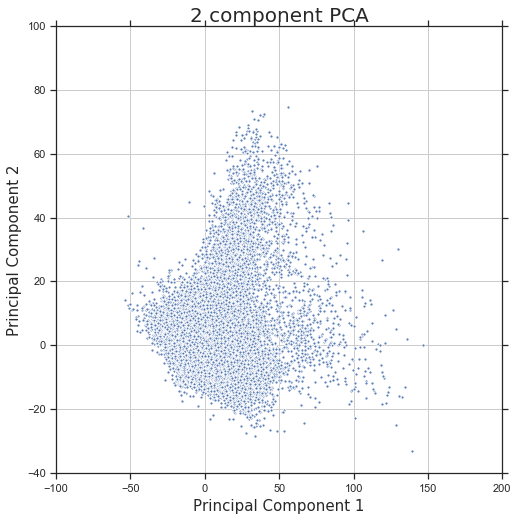

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(finalDf.loc[:, 'principal component 1']
           , finalDf.loc[:, 'principal component 2']
           , c = 'b'
           , s = 10
           , alpha = 0.9)
ax.grid()

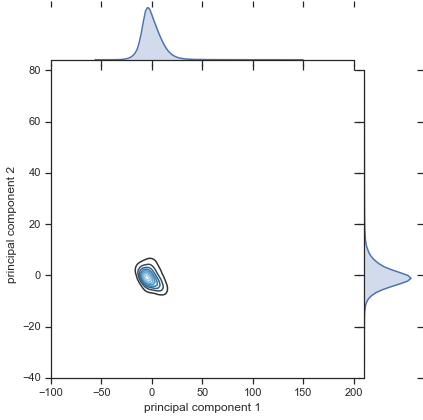

In [30]:
sns.set(style="white", color_codes=True)
snsPlot = sns.JointGrid(x=finalDf["principal component 1"], y=finalDf["principal component 2"])
snsPlot = snsPlot.plot_joint(sns.kdeplot, cmap="Blues_d")
snsPlot = snsPlot.plot_marginals(sns.kdeplot, shade=True)

## Variational AutoEncoder

In [26]:
class VAE(nn.Module):
    def __init__(self, hiddenSize = 100):
        super(VAE, self).__init__()
        self.hiddenSize = hiddenSize
        self.encoder = nn.Sequential(
            nn.Linear(978, 1000),
            nn.Tanh(),
            nn.Linear(1000, 1000),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(self.hiddenSize, 1000),
            nn.Tanh(),
            nn.Linear(1000, 1000),
            nn.Tanh(),
            nn.Linear(1000, 978),
            nn.Tanh())
        self.mu = torch.nn.Linear(1000, self.hiddenSize)
        self.logvar = torch.nn.Linear(1000, self.hiddenSize)

    def reparametrize(self, h):
        mu = self.mu(h)
        logvar = self.logvar(h)
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu), mu, logvar

    def forward(self, x):
        h1 = self.encoder[1](self.encoder[0](x))
        h = self.encoder[3](self.encoder[2](h1))
        z, mu, logvar = self.reparametrize(h)
        decoded = self.decoder(z)
        return decoded * 10, mu, logvar, z, h1
    
    def generate_sample(self):
        z = torch.FloatTensor(self.hiddenSize).normal_()
        return self.decoder(z)

In [27]:
reconstruction_function = nn.MSELoss()
def loss_function(recon_x, x, mu, logvar):
    """
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar) # KL(q(z|x)||p(z))
    KLD = torch.mean(KLD_element).mul_(-0.5)
    return BCE + KLD

### Start training

In [28]:
num_epochs = 300
learning_rate = 1e-3
batch_size = 512
model_VAE = VAE(hiddenSize = 100)
if torch.cuda.is_available():
    model_VAE.cuda()
optimizer = torch.optim.Adam(model_VAE.parameters(), lr = learning_rate)

In [29]:
useData = 'GP'
if useData == 'SM':
    expTrainDatasetSM, expValidDatasetSM = Tdata.random_split(expDatasetSM, [expDataSM.size()[0] - expDataSM.size()[0]//10, expDataSM.size()[0]//10])
    expTrainLoader = Tdata.DataLoader(dataset = expTrainDatasetSM, batch_size = batch_size, shuffle = True)
    expValidLoader = Tdata.DataLoader(dataset = expValidDatasetSM)
    print(len(expTrainLoader.dataset), len(expValidLoader.dataset))
elif useData == 'GP':
    expTrainDatasetGP, expValidDatasetGP = Tdata.random_split(expDatasetGP, [expDataGP.size()[0] - expDataGP.size()[0]//10, expDataGP.size()[0]//10])
    expTrainLoader = Tdata.DataLoader(dataset = expTrainDatasetGP, batch_size = batch_size, shuffle = True)
    expValidLoader = Tdata.DataLoader(dataset = expValidDatasetGP)
    print(len(expTrainLoader.dataset), len(expValidLoader.dataset))
elif useData == 'both':
    expTrainDatasetBoth, expValidDatasetBoth = Tdata.random_split(expDatasetBoth, [expDataBoth.size()[0] - expDataBoth.size()[0]//10, expDataBoth.size()[0]//10])
    expTrainLoader = Tdata.DataLoader(dataset = expTrainDatasetBoth, batch_size = batch_size, shuffle = True)
    expValidLoader = Tdata.DataLoader(dataset = expValidDatasetBoth)
    print(len(expTrainLoader.dataset), len(expValidLoader.dataset))
else:
    print("Error! Unidentified type of useData!")

(105104, 11678)


In [30]:
epoch_train_loss = []
startTime = time.time()
for epoch in range(num_epochs):
    model_VAE.train()
    lossList = []
    for step, data in enumerate(expTrainLoader):
        optimizer.zero_grad()
        inputData = data[0]
        if torch.cuda.is_available():
            inputData = inputData.cuda()
        recon_batch, mu, logvar, encoded, h1 = model_VAE(inputData)
        loss = loss_function(recon_batch, inputData, mu, logvar)
        loss.backward()
        optimizer.step()
        lossList.append(reconstruction_function(recon_batch, inputData).data.numpy())
    epochLoss = np.mean(lossList)
    epoch_train_loss.append(epochLoss)
    print('Epoch: ', epoch, '| train loss: %.4f' % epochLoss)
timeSpent = round(time.time() - startTime, 2)
print('Done.\nTime spent: ' + str(timeSpent) + 's.')

('Epoch: ', 0, '| train loss: 0.9887')
('Epoch: ', 1, '| train loss: 0.9188')
('Epoch: ', 2, '| train loss: 0.9116')
('Epoch: ', 3, '| train loss: 0.9060')
('Epoch: ', 4, '| train loss: 0.9031')
('Epoch: ', 5, '| train loss: 0.9009')
('Epoch: ', 6, '| train loss: 0.8992')
('Epoch: ', 7, '| train loss: 0.8969')
('Epoch: ', 8, '| train loss: 0.8957')
('Epoch: ', 9, '| train loss: 0.8946')
('Epoch: ', 10, '| train loss: 0.8933')
('Epoch: ', 11, '| train loss: 0.8916')
('Epoch: ', 12, '| train loss: 0.8910')
('Epoch: ', 13, '| train loss: 0.8903')
('Epoch: ', 14, '| train loss: 0.8896')
('Epoch: ', 15, '| train loss: 0.8891')
('Epoch: ', 16, '| train loss: 0.8884')
('Epoch: ', 17, '| train loss: 0.8873')
('Epoch: ', 18, '| train loss: 0.8866')
('Epoch: ', 19, '| train loss: 0.8861')
('Epoch: ', 20, '| train loss: 0.8857')
('Epoch: ', 21, '| train loss: 0.8846')
('Epoch: ', 22, '| train loss: 0.8835')
('Epoch: ', 23, '| train loss: 0.8834')
('Epoch: ', 24, '| train loss: 0.8825')
('Epoch: '

('Epoch: ', 203, '| train loss: 0.8623')
('Epoch: ', 204, '| train loss: 0.8624')
('Epoch: ', 205, '| train loss: 0.8623')
('Epoch: ', 206, '| train loss: 0.8624')
('Epoch: ', 207, '| train loss: 0.8622')
('Epoch: ', 208, '| train loss: 0.8625')
('Epoch: ', 209, '| train loss: 0.8621')
('Epoch: ', 210, '| train loss: 0.8624')
('Epoch: ', 211, '| train loss: 0.8623')
('Epoch: ', 212, '| train loss: 0.8621')
('Epoch: ', 213, '| train loss: 0.8625')
('Epoch: ', 214, '| train loss: 0.8622')
('Epoch: ', 215, '| train loss: 0.8624')
('Epoch: ', 216, '| train loss: 0.8621')
('Epoch: ', 217, '| train loss: 0.8622')
('Epoch: ', 218, '| train loss: 0.8622')
('Epoch: ', 219, '| train loss: 0.8623')
('Epoch: ', 220, '| train loss: 0.8623')
('Epoch: ', 221, '| train loss: 0.8624')
('Epoch: ', 222, '| train loss: 0.8624')
('Epoch: ', 223, '| train loss: 0.8622')
('Epoch: ', 224, '| train loss: 0.8621')
('Epoch: ', 225, '| train loss: 0.8619')
('Epoch: ', 226, '| train loss: 0.8618')
('Epoch: ', 227,

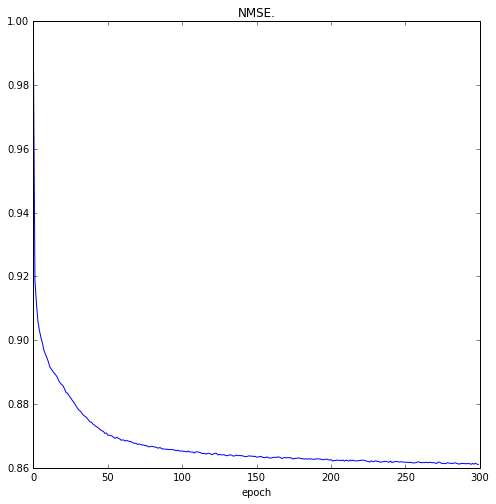

In [31]:
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.plot(epoch_train_loss)
ax.set_title('NMSE.')
ax.set_xlabel('epoch')

In [32]:
torch.save(model_VAE.encoder, 'VAE_encode.pth')
torch.save(model_VAE.mu, 'VAE_mu.pth')
torch.save(model_VAE.logvar, 'VAE_logvar.pth')
torch.save(model_VAE.decoder, 'VAE_decode.pth')

### Validation on independent dataset

In [33]:
model_VAE.eval()
validLossList = []
for data in expValidLoader:
    inputData = data[0]
    if torch.cuda.is_available():
        inputData = inputData.cuda()
    recon_batch, mu, logvar, _, _ = model_VAE(inputData)
    loss = reconstruction_function(recon_batch, inputData)
    validLossList.append(loss.data.numpy())
print('Validation loss: %.4f' % np.mean(validLossList))

Validation loss: 0.8641


## S-VQ-VAE

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### VQ function for S-VQ-VAE

In [76]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
        self._divergence_cost = divergence_cost
    
    def forward(self, inputs, label):
        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.reshape(label,(label.shape[0], 1))
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        close_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        close_encodings = torch.zeros(close_indices.shape[0], self._num_embeddings).to(device)
        close_encodings.scatter_(1, close_indices, 1)
        
        indicator = 1 - (encoding_indices == close_indices)
        indicator = indicator.float()
        
        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        close_quantized = torch.matmul(close_encodings, self._embedding.weight)
        
        # Loss
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        x_latent_loss = torch.mean(indicator * ((close_quantized - inputs.detach())**2))
        d_latent_loss = torch.mean(indicator * ((close_quantized.detach() - inputs)**2))
        loss = q_latent_loss + self._commitment_cost * e_latent_loss - x_latent_loss - self._divergence_cost * d_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized, perplexity, encodings

### VQ function for standard VQ-VAE

In [86]:
class VectorQuantizer_normal(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost):
        super(VectorQuantizer_normal, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost
    
    def forward(self, inputs, label):
        # Calculate distances
        distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings).to(device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize
        quantized = torch.matmul(encodings, self._embedding.weight)
        
        # Loss
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized, perplexity, encodings

In [87]:
class S_VQ_VAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, divergence_cost, decay=0):
        super(S_VQ_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(978, embedding_dim),
            nn.Tanh())
        
        if decay > 0.0:
            self._vq_vae = VectorQuantizer_normal(num_embeddings, embedding_dim, 
                                              commitment_cost, divergence_cost)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost, divergence_cost)
        
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 978),
            nn.Tanh())

    def forward(self, x, label):
        z = self.encoder(x)
        loss, quantized, perplexity, encodings = self._vq_vae(z, label)
        x_recon = self.decoder(quantized)
        x_recon = x_recon * 10
        return loss, x_recon, perplexity, encodings, quantized

In [88]:
def sparsePenalty(encoded, p):
    q = torch.mean(torch.abs(encoded), dim=0, keepdim=True)
    s1 = torch.sum(p * torch.log(p / q))
    s2 = torch.sum((1 - p) * torch.log((1 - p) / (1 - q)))
    return s1 + s2

### Start training

In [92]:
embedding_dim = 1000
num_embeddings = nClassSMC
commitment_cost = 0.25
divergence_cost = 0.1
decay = 0

num_epochs = 900
learning_rate = 1e-4
batch_size = 256

model_S_VQ_VAE = S_VQ_VAE(num_embeddings, embedding_dim, commitment_cost, divergence_cost, decay).to(device)
optimizer  = torch.optim.Adam(model_S_VQ_VAE.parameters(), lr=learning_rate, amsgrad=True)
criterion = nn.MSELoss()

In [90]:
expTrainDatasetSMCNP, expValidDatasetSMCNP = Tdata.random_split(expDatasetSMCNP, [expDataSMCNP.size()[0] - expDataSMCNP.size()[0]//10, expDataSMCNP.size()[0]//10])
expTrainLoader = Tdata.DataLoader(dataset = expTrainDatasetSMCNP, batch_size = batch_size, shuffle = True)
expValidLoader = Tdata.DataLoader(dataset = expValidDatasetSMCNP)
print(len(expTrainLoader.dataset), len(expValidLoader.dataset))

(8793, 976)


In [93]:
expTrainLoader = Tdata.DataLoader(dataset = expDatasetSMCNP, batch_size = batch_size, shuffle = True)
print(len(expTrainLoader.dataset))

9769


In [94]:
train_recon_error = []
train_perplexity = []
startTime = time.time()
for epoch in range(num_epochs):
    model_S_VQ_VAE.train()
    epoch_recon_error = []
    epoch_perplexity = []
    for step, data in enumerate(expTrainLoader):
        optimizer.zero_grad()
        inputData, label = data
        inputData = inputData.to(device)
        label = label.to(device)
        vq_loss, data_recon, perplexity, _, encoded = model_S_VQ_VAE(inputData, label)
        recon_error = criterion(data_recon, inputData)
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
    
        epoch_recon_error.append(recon_error.item())
        epoch_perplexity.append(perplexity.item())
    recon_error = np.mean(epoch_recon_error)
    mean_perplexity = np.mean(epoch_perplexity)
    train_recon_error.append(recon_error)
    train_perplexity.append(mean_perplexity)
    print('Epoch %d' % epoch)
    print('recon_error: %.3f' % recon_error)
    print('perplexity: %.3f' % mean_perplexity)
    print('')
timeSpent = round(time.time() - startTime, 2)
print('Done.\nTime spent: ' + str(timeSpent) + 's.')

Epoch 0
recon_error: 2.072
perplexity: 44.721

Epoch 1
recon_error: 2.011
perplexity: 44.878

Epoch 2
recon_error: 1.973
perplexity: 44.848

Epoch 3
recon_error: 1.934
perplexity: 44.966

Epoch 4
recon_error: 1.895
perplexity: 44.964

Epoch 5
recon_error: 1.883
perplexity: 44.813

Epoch 6
recon_error: 1.864
perplexity: 45.289

Epoch 7
recon_error: 1.863
perplexity: 44.978

Epoch 8
recon_error: 1.842
perplexity: 44.678

Epoch 9
recon_error: 1.842
perplexity: 44.996

Epoch 10
recon_error: 1.845
perplexity: 44.378

Epoch 11
recon_error: 1.849
perplexity: 44.727

Epoch 12
recon_error: 1.814
perplexity: 44.506

Epoch 13
recon_error: 1.820
perplexity: 44.986

Epoch 14
recon_error: 1.812
perplexity: 45.188

Epoch 15
recon_error: 1.831
perplexity: 45.050

Epoch 16
recon_error: 1.813
perplexity: 44.591

Epoch 17
recon_error: 1.798
perplexity: 44.973

Epoch 18
recon_error: 1.802
perplexity: 45.001

Epoch 19
recon_error: 1.794
perplexity: 44.812

Epoch 20
recon_error: 1.799
perplexity: 45.124

Ep

Epoch 170
recon_error: 1.753
perplexity: 45.073

Epoch 171
recon_error: 1.754
perplexity: 44.921

Epoch 172
recon_error: 1.756
perplexity: 44.629

Epoch 173
recon_error: 1.761
perplexity: 44.933

Epoch 174
recon_error: 1.767
perplexity: 44.809

Epoch 175
recon_error: 1.761
perplexity: 45.110

Epoch 176
recon_error: 1.765
perplexity: 44.912

Epoch 177
recon_error: 1.762
perplexity: 44.747

Epoch 178
recon_error: 1.765
perplexity: 44.836

Epoch 179
recon_error: 1.754
perplexity: 45.049

Epoch 180
recon_error: 1.769
perplexity: 44.986

Epoch 181
recon_error: 1.758
perplexity: 44.666

Epoch 182
recon_error: 1.764
perplexity: 44.886

Epoch 183
recon_error: 1.757
perplexity: 44.901

Epoch 184
recon_error: 1.754
perplexity: 44.983

Epoch 185
recon_error: 1.757
perplexity: 44.976

Epoch 186
recon_error: 1.786
perplexity: 45.120

Epoch 187
recon_error: 1.755
perplexity: 45.162

Epoch 188
recon_error: 1.754
perplexity: 44.832

Epoch 189
recon_error: 1.766
perplexity: 44.958

Epoch 190
recon_erro

Epoch 338
recon_error: 1.736
perplexity: 44.996

Epoch 339
recon_error: 1.751
perplexity: 44.850

Epoch 340
recon_error: 1.744
perplexity: 44.967

Epoch 341
recon_error: 1.753
perplexity: 45.178

Epoch 342
recon_error: 1.750
perplexity: 45.024

Epoch 343
recon_error: 1.744
perplexity: 45.133

Epoch 344
recon_error: 1.754
perplexity: 45.029

Epoch 345
recon_error: 1.738
perplexity: 45.227

Epoch 346
recon_error: 1.748
perplexity: 44.832

Epoch 347
recon_error: 1.740
perplexity: 44.959

Epoch 348
recon_error: 1.743
perplexity: 44.653

Epoch 349
recon_error: 1.748
perplexity: 44.651

Epoch 350
recon_error: 1.749
perplexity: 44.769

Epoch 351
recon_error: 1.754
perplexity: 44.829

Epoch 352
recon_error: 1.753
perplexity: 45.271

Epoch 353
recon_error: 1.757
perplexity: 44.938

Epoch 354
recon_error: 1.755
perplexity: 45.097

Epoch 355
recon_error: 1.742
perplexity: 44.932

Epoch 356
recon_error: 1.746
perplexity: 45.122

Epoch 357
recon_error: 1.738
perplexity: 44.644

Epoch 358
recon_erro

Epoch 506
recon_error: 1.752
perplexity: 44.830

Epoch 507
recon_error: 1.749
perplexity: 44.538

Epoch 508
recon_error: 1.747
perplexity: 44.837

Epoch 509
recon_error: 1.754
perplexity: 44.882

Epoch 510
recon_error: 1.764
perplexity: 44.884

Epoch 511
recon_error: 1.739
perplexity: 44.681

Epoch 512
recon_error: 1.754
perplexity: 44.989

Epoch 513
recon_error: 1.745
perplexity: 44.502

Epoch 514
recon_error: 1.741
perplexity: 44.812

Epoch 515
recon_error: 1.739
perplexity: 44.796

Epoch 516
recon_error: 1.752
perplexity: 44.553

Epoch 517
recon_error: 1.732
perplexity: 45.131

Epoch 518
recon_error: 1.741
perplexity: 44.847

Epoch 519
recon_error: 1.741
perplexity: 44.917

Epoch 520
recon_error: 1.741
perplexity: 44.897

Epoch 521
recon_error: 1.737
perplexity: 44.708

Epoch 522
recon_error: 1.748
perplexity: 44.862

Epoch 523
recon_error: 1.736
perplexity: 44.638

Epoch 524
recon_error: 1.735
perplexity: 44.930

Epoch 525
recon_error: 1.735
perplexity: 44.748

Epoch 526
recon_erro

Epoch 674
recon_error: 1.738
perplexity: 45.138

Epoch 675
recon_error: 1.742
perplexity: 44.606

Epoch 676
recon_error: 1.733
perplexity: 44.800

Epoch 677
recon_error: 1.732
perplexity: 44.711

Epoch 678
recon_error: 1.742
perplexity: 44.772

Epoch 679
recon_error: 1.741
perplexity: 44.644

Epoch 680
recon_error: 1.738
perplexity: 44.988

Epoch 681
recon_error: 1.743
perplexity: 45.283

Epoch 682
recon_error: 1.739
perplexity: 45.007

Epoch 683
recon_error: 1.736
perplexity: 44.606

Epoch 684
recon_error: 1.736
perplexity: 45.011

Epoch 685
recon_error: 1.750
perplexity: 44.748

Epoch 686
recon_error: 1.734
perplexity: 44.955

Epoch 687
recon_error: 1.735
perplexity: 44.881

Epoch 688
recon_error: 1.742
perplexity: 44.860

Epoch 689
recon_error: 1.737
perplexity: 44.948

Epoch 690
recon_error: 1.737
perplexity: 44.464

Epoch 691
recon_error: 1.738
perplexity: 44.762

Epoch 692
recon_error: 1.735
perplexity: 44.512

Epoch 693
recon_error: 1.745
perplexity: 44.668

Epoch 694
recon_erro

Epoch 842
recon_error: 1.729
perplexity: 44.974

Epoch 843
recon_error: 1.744
perplexity: 44.912

Epoch 844
recon_error: 1.740
perplexity: 45.075

Epoch 845
recon_error: 1.750
perplexity: 44.759

Epoch 846
recon_error: 1.738
perplexity: 45.004

Epoch 847
recon_error: 1.734
perplexity: 44.749

Epoch 848
recon_error: 1.750
perplexity: 44.993

Epoch 849
recon_error: 1.731
perplexity: 44.766

Epoch 850
recon_error: 1.742
perplexity: 45.185

Epoch 851
recon_error: 1.733
perplexity: 44.997

Epoch 852
recon_error: 1.743
perplexity: 44.993

Epoch 853
recon_error: 1.728
perplexity: 44.666

Epoch 854
recon_error: 1.743
perplexity: 44.804

Epoch 855
recon_error: 1.735
perplexity: 44.632

Epoch 856
recon_error: 1.737
perplexity: 44.924

Epoch 857
recon_error: 1.739
perplexity: 44.684

Epoch 858
recon_error: 1.752
perplexity: 44.974

Epoch 859
recon_error: 1.748
perplexity: 44.988

Epoch 860
recon_error: 1.731
perplexity: 44.878

Epoch 861
recon_error: 1.730
perplexity: 44.630

Epoch 862
recon_erro

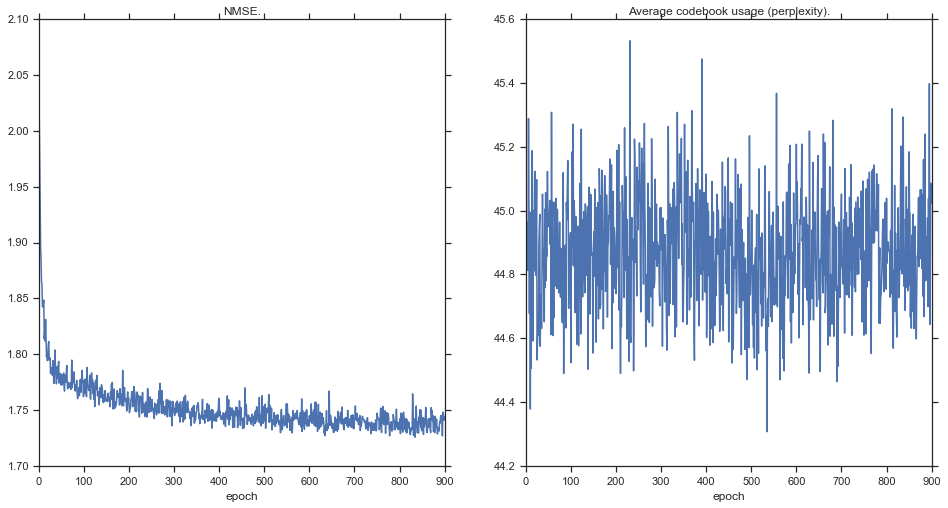

In [95]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_error)
ax.set_title('NMSE.')
ax.set_xlabel('epoch')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('epoch')

In [96]:
torch.save(model_S_VQ_VAE.encoder, 'S_VQ_VAE_encode.pth')
torch.save(model_S_VQ_VAE._vq_vae._embedding, 'S_VQ_VAE_embedding.pth')
torch.save(model_S_VQ_VAE.decoder, 'S_VQ_VAE_decode.pth')

### Validation on independent dataset

In [54]:
model_S_VQ_VAE.eval()
validLossList = []
for step, data in enumerate(expValidLoader):
    inputData, label = data
    inputData = inputData.to(device)
    label = label.to(device)
    vq_loss, data_recon, _, _, _= model_S_VQ_VAE(inputData, label)
    recon_error = criterion(data_recon, inputData)
    loss = recon_error + vq_loss
    validLossList.append(recon_error.item())
print('Validation loss: %.4f' % np.mean(validLossList))

Validation loss: 1.8758
